<a href="https://colab.research.google.com/github/TyamanovaMargo/identification/blob/main/%22BERT_MULTICLASSIFICATION_GENRE_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wget
!pip install transformers

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=ca9d7955871b9e3e617156cc2da484400e15708f007035c986f3a4f24670e12a
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


# BERT Fine Tuning for Multi Class Text Classification

This notebook contains code to fine tune a pretrained BERT language model to a specific classification task.
As BERT model interface the Huggingface library with a PyTorch backend is used.

In this notebook, the model has been fine tuned with the German 10kGNAD Dataset but could easily be fine tuned on any other classification dataset.

The code was implemented based on the huggingface example scripts for glue tasks fine tuning (https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128) and the blog post by Chris McCormick (http://mccormickml.com/2019/07/22/BERT-fine-tuning/).


In [3]:
import os
import time
import datetime
import random
from google.colab import drive

import pandas as pd
import numpy as np
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score

from transformers import AutoModelForSequenceClassification
from transformers import AutoConfig
from torch.optim import AdamW
from transformers import AutoTokenizer
from transformers import get_linear_schedule_with_warmup

import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
import IPython

import torch
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

## Load data

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [78]:
# Download dataset
# df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Multiclassification_dataset/dataset_all_pos_dir_multiclass_low_case.csv",
#                  encoding="utf-8",
#                  header=0)

# df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Multiclassification_dataset/dataset_all_pos_dir_multiclass.csv",
#                  encoding="utf-8",
#                  header=0)

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Multiclassification_dataset/dataset_all_pos_dir_multiclass_first_chunk.csv",
                 encoding="utf-8",
                 header=0)

# Download dataset without punctuation
# df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Multiclassification_dataset/dataset_all_pos_dir_multiclass_without_punc_FILTERED_nun.csv',
#                 encoding="utf-8")
#                 #  skiprows=1,)


In [79]:
print(df.head())




                                                text  label
0  Дом потерянных душ Романтические детективы Евг...      0
1  Стихи для мертвецов Дуглас Престон Звезды миро...      0
2  Сказка о смерти Мартен С. Снейдер #3 В Берне о...      0
3  Темная материя Город в Нигде Джейсон Дессен, в...      0
4  Позже Темная башня (АСТ) Джейми Конклин, живущ...      0


In [80]:
texts = df.text.values
label_cats = df.label.astype('category').cat
print(label_cats)
# List of label names (str)
label_names = label_cats.categories
print(label_names)
# List of label ids (int, in range (0,num_classes-1))
labels = label_cats.codes
print(labels)



Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype='int64')
0        0
1        0
2        0
3        0
4        0
        ..
7329    10
7330    10
7331    10
7332    10
7333    10
Length: 7334, dtype: int8


In [81]:
print("Label Names (should be 0 to 10):", label_names)
print("Labels (should match Label Names):", labels[:10])


Label Names (should be 0 to 10): Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype='int64')
Labels (should match Label Names): 0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
dtype: int8


In [82]:
import pandas as pd

# Example DataFrame (assuming you have loaded it already)
# df = pd.read_csv('your_file.csv')

# Ensure that labels are correctly mapped and exclude any non-numeric entries
label_cats = df.label.astype('category').cat
label_names = label_cats.categories

# Map labels to integers
labels = label_cats.codes

# Create a DataFrame with text and corresponding labels
df_mapped = df.copy()
df_mapped['label_mapped'] = labels

# Print out the first few rows of the DataFrame to verify
print(df_mapped[['text', 'label_mapped']].head())
print(df_mapped[['text', 'label_mapped']].iloc[500:510])
print(df_mapped[['text', 'label_mapped']].tail())

                                                text  label_mapped
0  Дом потерянных душ Романтические детективы Евг...             0
1  Стихи для мертвецов Дуглас Престон Звезды миро...             0
2  Сказка о смерти Мартен С. Снейдер #3 В Берне о...             0
3  Темная материя Город в Нигде Джейсон Дессен, в...             0
4  Позже Темная башня (АСТ) Джейми Конклин, живущ...             0
                                                  text  label_mapped
500  Регуляторы Тэк #2 Прекрасный летний денек в ма...             0
501  Девушка из моря Национальный бестселлер Британ...             0
502  Убийственно жив Неизвестный маньяк не просто у...             0
503  Мактуб. Ядовитый любовник Лана Мейер Восточные...             0
504  Фирма Эта фирма погасила его кредит. Предостав...             0
505  Летающие убийцы Спецназ ГРУ В горах Кавказа об...             0
506  Игра с огнем (сборник) Звезды мирового детекти...             0
507  Родная кровь В глубине штата Мэн, на бере

## Tokenize Data

In [83]:
# model_name = "DeepPavlov/rubert-base-cased"
# model_name ='DeepPavlov/rubert-base-cased'
model_name ='bert-base-multilingual-cased'
MAX_INPUT_LENGTH = 512

In [84]:
# Load the pretrained BERT tokenizer.
print(f"Loading {model_name} tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(model_name)

Loading bert-base-multilingual-cased tokenizer...


In [85]:
input_ids = []
attention_masks = []

for text in texts:
    encoded_dict = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=MAX_INPUT_LENGTH,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

# Convert lists to tensors
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels, dtype=torch.long)

# Print the results for debugging
print('Original Text:', texts[0])
print('Token IDs:', input_ids[0])
print('Attention Mask:', attention_masks[0])





Original Text: Дом потерянных душ Романтические детективы Евгении Кретовой #7 Аделия – потомственная ясновидящая. Во всяком случае, так написано на вывеске ее салона. Поток клиенток, гадания, натальные карты и никакой романтики. Но накануне праздников что-то идет не так: клиентка не может определиться с невестой для сына, проблемы у сестры, странный тип не оставляет Аделию в покое. В итоге она волей-неволей оказывается вовлечена в тайны чужой семейной жизни. Те самые, что обычно прячутся скелетами в шкафу. Романтика, остро приправленная мистикой и загадкой старого преступления – новый детектив от Евгении Кретовой. Дом потерянных душ Пролог Она шагнула к кромке воды, безразлично наблюдая, как темная вода лизнула покрасневшие пальцы на ногах. Потянула за край рубашки, стянула через голову и, не оглядываясь, отбросила прочь, в траву. И только тогда посмотрела через плечо. Шагнула в воду. Ноги скользили по вязкой глине, приходилось цепляться за камыш, пробираться сквозь него осторожно, зяб

In [86]:
print(tokenizer.encode_plus(
    texts[0],
    add_special_tokens=True,
    max_length=MAX_INPUT_LENGTH,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
))



{'input_ids': tensor([[   101,  37106,  10297,  15469,  18971,  10970,  11576,  11148,  36314,
          65446,  89353,  59990,  18221,    514,  10541,  14276,  11905,    519,
          40035,  17780,    108,    128,    509,  44030,  11502,    100,  37706,
          48310,  96947,  53156,  10385,  26325,    119,  12624,  72782,  13393,
          28127,    117,  12123,  10122,  48680,  10122,  96195,  14149,  14430,
          75431,  10868,  35551,  10179,    119,  11480,  20422,    551,  10783,
          28252,  11899,    117,  16616,  72216,    117,  10122,  44422,  34045,
          73985,    549,  19544,  67967,  10384,  25122,  31399,    119,  19732,
          10122,  17343,  86622,  59784,  41637,  10433,  10791,    118,  11663,
            549,  82635,  10375,  12123,    131,    551,  10783,  28252,  10521,
          10375,  16087,    555,  35415,  87097, 106364,  10625,    558,  10375,
          14149,  98526,  10520,  37060,    117,  44536,    560,  10277,  95212,
            11

In [87]:
for i in range(5):  # Check first 5 texts
    print(f"\nOriginal Text {i}:", texts[i])
    print(f"Token IDs {i}:", input_ids[i])
    print(f"Attention Mask {i}:", attention_masks[i])
    print(f"Number of 0s in Token IDs {i}:", (input_ids[i] == 0).sum().item())
    print(f"Number of 0s in Attention Mask {i}:", (attention_masks[i] == 0).sum().item())



Original Text 0: Дом потерянных душ Романтические детективы Евгении Кретовой #7 Аделия – потомственная ясновидящая. Во всяком случае, так написано на вывеске ее салона. Поток клиенток, гадания, натальные карты и никакой романтики. Но накануне праздников что-то идет не так: клиентка не может определиться с невестой для сына, проблемы у сестры, странный тип не оставляет Аделию в покое. В итоге она волей-неволей оказывается вовлечена в тайны чужой семейной жизни. Те самые, что обычно прячутся скелетами в шкафу. Романтика, остро приправленная мистикой и загадкой старого преступления – новый детектив от Евгении Кретовой. Дом потерянных душ Пролог Она шагнула к кромке воды, безразлично наблюдая, как темная вода лизнула покрасневшие пальцы на ногах. Потянула за край рубашки, стянула через голову и, не оглядываясь, отбросила прочь, в траву. И только тогда посмотрела через плечо. Шагнула в воду. Ноги скользили по вязкой глине, приходилось цепляться за камыш, пробираться сквозь него осторожно, 

In [88]:
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 80-10-10 train-validation-test split

# Calculate the number of samples to include in each set.
train_size = int(0.7 * len(dataset))
print(len(dataset))
val_size = int(0.1* len(dataset))
test_size = len(dataset) - train_size - val_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print(f"{train_size} training samples")
print(f"{val_size} validation samples")
print(f"{test_size} test samples")



7334
5133 training samples
733 validation samples
1468 test samples


In [89]:
# The DataLoader needs to know our batch size for training, so we specify it
# here. For fine-tuning BERT on a specific task, the authors recommend a batch
# size of 16 or 32.
batch_size = 16

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
        )

# For test the order doesn't matter, so we'll just read them sequentially.
test_dataloader = DataLoader(
            test_dataset,
            sampler = SequentialSampler(test_dataset),
            batch_size = batch_size
        )

In [61]:
# Function to print DataLoader details
def print_dataloader_details(dataloader, name):
    print(f"Details of {name}:")
    # Print number of batches
    print(f"Number of batches: {len(dataloader)}")
    # Print batch size
    batch_size = dataloader.batch_size
    print(f"Batch size: {batch_size}")

    # Print details of the first batch
    first_batch = next(iter(dataloader))
    print("\nDetails of the first batch:")
    print(f"Input IDs shape: {first_batch[0].shape}")
    print(f"Attention Masks shape: {first_batch[1].shape}")
    print(f"Labels shape: {first_batch[2].shape}")

# Print details for training, validation, and test dataloaders
print_dataloader_details(train_dataloader, "Training DataLoader")
print_dataloader_details(validation_dataloader, "Validation DataLoader")
print_dataloader_details(test_dataloader, "Test DataLoader")


Details of Training DataLoader:
Number of batches: 322
Batch size: 16

Details of the first batch:
Input IDs shape: torch.Size([16, 512])
Attention Masks shape: torch.Size([16, 512])
Labels shape: torch.Size([16])
Details of Validation DataLoader:
Number of batches: 46
Batch size: 16

Details of the first batch:
Input IDs shape: torch.Size([16, 512])
Attention Masks shape: torch.Size([16, 512])
Labels shape: torch.Size([16])
Details of Test DataLoader:
Number of batches: 92
Batch size: 16

Details of the first batch:
Input IDs shape: torch.Size([16, 512])
Attention Masks shape: torch.Size([16, 512])
Labels shape: torch.Size([16])


## Create and Train Model

In [90]:
from transformers import AutoModelForSequenceClassification, AutoConfig



# Load pretrained model for sequence classification
print(f"Loading {model_name} model...")
config = AutoConfig.from_pretrained(model_name)

# Set the number of labels (number of classes)
config.num_labels = len(label_names)  # Ensure this is set to 11 for 0-10 labels

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    config=config
)

# Tell pytorch to run this model on the GPU.
model.cuda()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading bert-base-multilingual-cased model...


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [91]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (119547, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (768,

In [92]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5, у меня 1e-3
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [93]:
# Number of training epochs. The BERT authors recommend between 2 and 4.
epochs = 16

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

epochs=3

In [94]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [95]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [96]:
import time
import random
import numpy as np
import torch
from torch.utils.data import DataLoader

# Set the seed value for reproducibility
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example model initialization (replace with your model)
# model = YourModelClass().to(device)

# Example dataloaders (replace with your dataloaders)
# train_dataloader = DataLoader(...)
# validation_dataloader = DataLoader(...)

# Example optimizer and scheduler (replace with your optimizer and scheduler)
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

def format_time(seconds):
    """Converts a time in seconds into a string of format h:mm:ss"""
    return str(time.strftime("%H:%M:%S", time.gmtime(seconds)))

def train():
    """Function to train the model"""
    model.train()
    total_train_loss = 0

    for step, batch in enumerate(train_dataloader):
        if step % 40 == 0 and step != 0:
            elapsed = format_time(time.time() - t0)
            print(f'  Batch {step:>5,} of {len(train_dataloader):>5,}. Elapsed: {elapsed}.')

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()
        outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask, labels=b_labels)

        # Check the outputs to handle the unpacking
        if isinstance(outputs, tuple):
            loss = outputs[0]
            logits = outputs[1]
        else:
            # Handle cases where the model might return a single output
            loss = outputs.loss
            logits = outputs.logits

        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    return avg_train_loss

def evaluate():
    """Function to evaluate the model"""
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0

    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask, labels=b_labels)

        if isinstance(outputs, tuple):
            loss = outputs[0]
            logits = outputs[1]
        else:
            loss = outputs.loss
            logits = outputs.logits

        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.cpu().numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids)

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    return avg_val_loss, avg_val_accuracy

# Training loop
epochs = epochs  # Set your number of epochs
training_stats = []
total_t0 = time.time()

for epoch_i in range(epochs):
    print(f"\n======== Epoch {epoch_i + 1} / {epochs} ========")
    print("Training...")

    t0 = time.time()
    avg_train_loss = train()
    training_time = format_time(time.time() - t0)

    print(f"  Average training loss: {avg_train_loss:.2f}")
    print(f"  Training epoch took: {training_time}")

    print("\nRunning Validation...")
    t0 = time.time()
    avg_val_loss, avg_val_accuracy = evaluate()
    validation_time = format_time(time.time() - t0)

    print(f"  Validation Loss: {avg_val_loss:.2f}")
    print(f"  Validation Accuracy: {avg_val_accuracy:.2f}")
    print(f"  Validation took: {validation_time}")

    training_stats.append({
        'epoch': epoch_i + 1,
        'Training Loss': avg_train_loss,
        'Valid. Loss': avg_val_loss,
        'Valid. Accur.': avg_val_accuracy,
        'Training Time': training_time,
        'Validation Time': validation_time
    })

print(f"\nTraining complete! Total training took {format_time(time.time() - total_t0)} (h:mm:ss)")





======== Epoch 1 / 3 ========
Training...
  Batch    40 of   321. Elapsed: 00:00:26.
  Batch    80 of   321. Elapsed: 00:00:54.
  Batch   120 of   321. Elapsed: 00:01:22.
  Batch   160 of   321. Elapsed: 00:01:50.
  Batch   200 of   321. Elapsed: 00:02:18.
  Batch   240 of   321. Elapsed: 00:02:47.
  Batch   280 of   321. Elapsed: 00:03:15.
  Batch   320 of   321. Elapsed: 00:03:42.
  Average training loss: 1.76
  Training epoch took: 00:03:43

Running Validation...
  Validation Loss: 1.32
  Validation Accuracy: 0.57
  Validation took: 00:00:11

======== Epoch 2 / 3 ========
Training...
  Batch    40 of   321. Elapsed: 00:00:27.
  Batch    80 of   321. Elapsed: 00:00:55.
  Batch   120 of   321. Elapsed: 00:01:23.
  Batch   160 of   321. Elapsed: 00:01:51.
  Batch   200 of   321. Elapsed: 00:02:19.
  Batch   240 of   321. Elapsed: 00:02:47.
  Batch   280 of   321. Elapsed: 00:03:15.
  Batch   320 of   321. Elapsed: 00:03:43.
  Average training loss: 1.21
  Training epoch took: 00:03:44

In [97]:
import pandas as pd

# Set float display precision to two decimal places.
pd.set_option('display.float_format', lambda x: f'{x:.2f}')

# Create a DataFrame from your training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
print(df_stats)


       Training Loss  Valid. Loss  Valid. Accur. Training Time Validation Time
epoch                                                                         
1               1.76         1.32           0.57      00:03:43        00:00:11
2               1.21         1.18           0.59      00:03:44        00:00:11
3               0.99         1.19           0.60      00:03:44        00:00:11


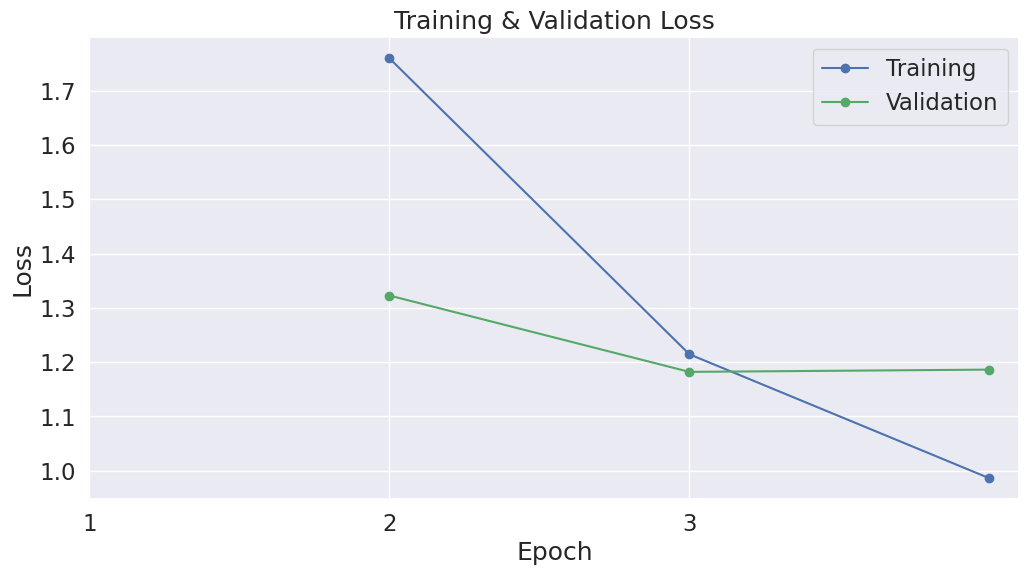

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot styling
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plotting
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Labeling
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks(ticks=range(len(df_stats.index)), labels=df_stats.index)

# Show plot
plt.show()


## Evaluation on Test Set

In [107]:
# Prediction on test set

print("Predicting labels ...")

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in test_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(input_ids=b_input_ids,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.extend(logits)
  true_labels.extend(label_ids)

print(f"Predicted {len(predictions)} samples")

Predicting labels ...
Predicted 1468 samples


In [108]:
predictions = np.argmax(predictions, axis=1)
print(f"Test set accuracy: {accuracy_score(true_labels, predictions)}")
print(f"Test set Matthews correlation coefficient: {matthews_corrcoef(true_labels, predictions)}")

Test set accuracy: 0.5783378746594006
Test set Matthews correlation coefficient: 0.5228691533710695


In [109]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report

# Prediction on test set
print("Predicting labels ...")

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions, true_labels, all_logits = [], [], []

# Predict
for batch in test_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    test_dataloader
    # Store logits and true labels
    all_logits.extend(logits)
    true_labels.extend(label_ids)

# Convert logits to class labels
predictions = np.argmax(all_logits, axis=1)
true_labels = np.array(true_labels).flatten()

# Generate classification report
report = classification_report(true_labels, predictions, output_dict=True, zero_division=0)

# Print the classification report
print(classification_report(true_labels, predictions, zero_division=0))

# Save the classification report to a CSV file
report_df = pd.DataFrame(report).transpose()
report_df.to_csv('classification_report.csv', index=True)

print("Classification report saved to 'classification_report.csv'")

# Create a DataFrame for detailed predictions after argmax
detailed_predictions_df = pd.DataFrame({
    'True Label': true_labels,
    'Predicted Label': predictions,
    'Logits': [logit.tolist() for logit in all_logits]  # Convert logits to list for CSV storage
})

# Save detailed predictions to a CSV file
detailed_predictions_df.to_csv('detailed_predictions.csv', index=False)

print("Detailed predictions saved to 'detailed_predictions.csv'")



Predicting labels ...
              precision    recall  f1-score   support

           0       0.37      0.53      0.43       109
           1       0.33      0.04      0.07        24
           2       0.68      0.58      0.63       194
           3       0.52      0.63      0.57       207
           4       0.59      0.54      0.56       211
           5       0.00      0.00      0.00        36
           6       0.65      0.75      0.69       204
           7       0.74      0.59      0.66        96
           8       0.50      0.39      0.44        61
           9       0.78      0.78      0.78       153
          10       0.44      0.45      0.45       173

    accuracy                           0.58      1468
   macro avg       0.51      0.48      0.48      1468
weighted avg       0.57      0.58      0.57      1468

Classification report saved to 'classification_report.csv'
Detailed predictions saved to 'detailed_predictions.csv'


In [36]:
# Get training predictions and labels
train_predictions = []
train_true_labels = []

for batch in train_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask)
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    predictions = np.argmax(logits, axis=1)

    train_predictions.extend(predictions)
    train_true_labels.extend(label_ids)

# Generate training classification report
train_report = classification_report(train_true_labels, train_predictions, output_dict=True, zero_division=0)
print("Training classification report:\n", train_report)


Training classification report:
 {'0': {'precision': 0.5, 'recall': 0.020642201834862386, 'f1-score': 0.039647577092511016, 'support': 436.0}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 84.0}, '2': {'precision': 0.3991060025542784, 'recall': 0.9018759018759018, 'f1-score': 0.5533421868083223, 'support': 693.0}, '3': {'precision': 0.6673387096774194, 'recall': 0.49774436090225566, 'f1-score': 0.570198105081826, 'support': 665.0}, '4': {'precision': 0.6181575433911882, 'recall': 0.6739446870451238, 'f1-score': 0.6448467966573816, 'support': 687.0}, '5': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 154.0}, '6': {'precision': 0.7221238938053097, 'recall': 0.5770862800565771, 'f1-score': 0.6415094339622641, 'support': 707.0}, '7': {'precision': 0.6351351351351351, 'recall': 0.7366771159874608, 'f1-score': 0.6821480406386067, 'support': 319.0}, '8': {'precision': 0.45933014354066987, 'recall': 0.463768115942029, 'f1-score': 0.46153846153846156, 'suppo

## Save model to disk

In [ ]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = f"./{model_name}/"

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print(f"Saving model to {output_dir}")

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
#torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to ./DeepPavlov/rubert-base-cased/


('./DeepPavlov/rubert-base-cased/tokenizer_config.json',
 './DeepPavlov/rubert-base-cased/special_tokens_map.json',
 './DeepPavlov/rubert-base-cased/vocab.txt',
 './DeepPavlov/rubert-base-cased/added_tokens.json',
 './DeepPavlov/rubert-base-cased/tokenizer.json')

In [ ]:
# Mount Google Drive to this Notebook instance.
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Copy the model files to a directory in your Google Drive.
target_dir = f"\"./drive/My Drive/NLP/BERT CLF 10kGNAD/\""
!cp -r $output_dir $target_dir

## Load Model from Drive

In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
output_dir = f"./content/drive/MyDrive/Colab Notebooks/{model_name}/"

# Load a trained model and vocabulary that you have fine-tuned
model = AutoModelForSequenceClassification.from_pretrained(output_dir)
tokenizer = AutoTokenizer.from_pretrained(output_dir)

# Copy the model to the GPU.
model.to(device)

Mounted at /content/drive


OSError: Incorrect path_or_model_id: './content/drive/MyDrive/Colab Notebooks/DeepPavlov/rubert-base-cased/'. Please provide either the path to a local folder or the repo_id of a model on the Hub.

## Predict on some sample text

### Prediction

In [ ]:
texts = ["Heldt hätte kein Problem damit, wenn es in zwei Wochen in der Bundesliga wieder losgehen würde. „Wir lernen gerade alle, Kompromisse einzugehen, an die wir vor Wochen noch nicht gedacht haben.“ Natürlich seien zehn bis 14 Tage richtiges Mannschaftstraining sinnvoll. „Aber vielleicht kriegen wir diese Zeit nicht. Und dann machen wir es so“, ergänzte der langjährige Manager. Köln-Profi Birger Verstraete hält die Maßnahmen nach den drei positiven Corona-Tests derweil für leichtsinnig. „Wir sollten vorerst nicht unter Quarantäne gestellt werden, und das ist ein bisschen bizarr“, sagte der belgische Mittelfeldspieler dem TV-Sender „VTM“. Beim 1. FC Köln waren zwei Spieler und ein Betreuer positiv auf das Coronavirus getestet worden. „Der Physiotherapeut ist der Mann, der mich und andere Spieler wochenlang behandelt hat. Und mit einem der beiden fraglichen Spieler habe ich am Donnerstag im Fitnessstudio ein Duo gebildet“, sagte Verstraete in dem Interview, über das „Het Laatste Nieuws berichtete."]

In [ ]:
input_ids = []
attention_masks = []

for text in texts:
  encoded_dict = tokenizer.encode_plus(
                          text,
                          add_special_tokens = True,
                          max_length = 64,
                          pad_to_max_length = True,
                          return_attention_mask = True,
                          return_tensors = 'pt')

  # Add the encoded sentence to the list.
  input_ids.append(encoded_dict['input_ids'])

  # And its attention mask (simply differentiates padding from non-padding).
  attention_masks.append(encoded_dict['attention_mask'])

  # Convert the lists into tensors.
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)

In [ ]:
# Put model in evaluation mode
model.eval()

predictions = []
last_layer_attentions = []

# Move input ids and attention masks to GPU
input_ids = input_ids.to(device)
attention_masks = attention_masks.to(device)

for i in range(len(input_ids)):

  ids = input_ids[i].unsqueeze(0)
  masks = attention_masks[i].unsqueeze(0)

  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(input_ids=ids,
                      attention_mask=masks)

  # Get logits and compute softmax
  logits = outputs[0]
  logits = torch.softmax(logits,dim=1)
  last_layer_attention = outputs[1][-1]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  last_layer_attention = last_layer_attention.detach().cpu().numpy()

  last_layer_attentions.append(last_layer_attention)
  predictions.append(logits)

In [ ]:
probs = predictions[0][0]
print("text:", texts[0])
print("predictions:", probs)
pred_idx = np.argmax(probs)
print(f"Prediction: {label_names[pred_idx]} ({probs[pred_idx]:.2f})", )

text: Heldt hätte kein Problem damit, wenn es in zwei Wochen in der Bundesliga wieder losgehen würde. „Wir lernen gerade alle, Kompromisse einzugehen, an die wir vor Wochen noch nicht gedacht haben.“ Natürlich seien zehn bis 14 Tage richtiges Mannschaftstraining sinnvoll. „Aber vielleicht kriegen wir diese Zeit nicht. Und dann machen wir es so“, ergänzte der langjährige Manager. Köln-Profi Birger Verstraete hält die Maßnahmen nach den drei positiven Corona-Tests derweil für leichtsinnig. „Wir sollten vorerst nicht unter Quarantäne gestellt werden, und das ist ein bisschen bizarr“, sagte der belgische Mittelfeldspieler dem TV-Sender „VTM“. Beim 1. FC Köln waren zwei Spieler und ein Betreuer positiv auf das Coronavirus getestet worden. „Der Physiotherapeut ist der Mann, der mich und andere Spieler wochenlang behandelt hat. Und mit einem der beiden fraglichen Spieler habe ich am Donnerstag im Fitnessstudio ein Duo gebildet“, sagte Verstraete in dem Interview, über das „Het Laatste Nieuws 

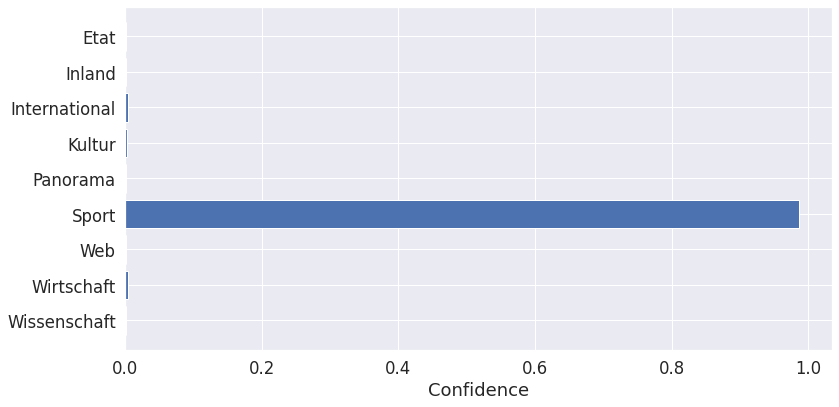

In [ ]:
fig = plt.figure(tight_layout=True)
ax = fig.add_subplot(1, 1, 1)

y_pos = np.arange(len(label_names))
confidences = [probs[i] for i in range(len(label_names))]

ax.barh(y_pos, confidences, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(label_names)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Confidence')

fig.show()

### Visualize Attentions

For each token, visualize the average over all 12 heads of the last layer's attention to the special character [CLS]. The darker the background of the token, the higher its attention

In [ ]:
lla = last_layer_attentions[0][0][:,0,:]

In [ ]:
def avg_token_attentions(last_layer_attentions):
  return last_layer_attentions.mean(axis=0)

In [ ]:
avg_token_atts = avg_token_attentions(lla)
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

In [ ]:
def handle_special_token_attentions(tokens, avg_token_atts):
  new_tokens = []
  new_avg_token_atts = []
  for i in range(len(tokens)):
    if tokens[i].startswith("[") or tokens[i].startswith("##"):
      continue
    if i < tokenizer.max_len - 1 and tokens[i+1].startswith("##"):
      merged_tokens = tokens[i] + tokens[i+1][2:]
      atts = [avg_token_atts[i], avg_token_atts[i+1]]
      i += 1
      while i < tokenizer.max_len - 1 and tokens[i+1].startswith("##"):
        merged_tokens += tokens[i+1][2:]
        atts.append(avg_token_atts[i+1])
        i += 1
      new_tokens.append(merged_tokens)
      new_avg_token_atts.append(sum(atts)/len(atts))
    elif i < tokenizer.max_len - 1:
      new_tokens.append(tokens[i])
      new_avg_token_atts.append(avg_token_atts[i])
  new_avg_token_atts = new_avg_token_atts / sum(new_avg_token_atts)
  return new_tokens, new_avg_token_atts

In [ ]:
tokens, avg_token_atts = handle_special_token_attentions(tokens, avg_token_atts)

In [ ]:
for token, att in zip(tokens, avg_token_atts):
  print(token, att)

Heldt 0.05963272150050977
hätte 0.05842705044356964
kein 0.015847744346937087
Problem 0.01636351010862091
damit 0.013772409461545421
, 0.036807565532129716
wenn 0.03087712355309333
es 0.024819269697866908
in 0.018017946361961145
zwei 0.017895302157496278
Wochen 0.03003063986432607
in 0.025940210667872093
der 0.023251029511036282
Bundesliga 0.05716164042458836
wieder 0.01203980647078767
losgehen 0.00583129451285671
würde 0.03879455071515468
. 0.12072620863387562
Wir 0.019060273146967795
lernen 0.012353933512564218
gerade 0.00628229120688047
alle 0.010505001215702199
, 0.012323023127170943
Kompromisse 0.0056848631707390965
einzugehen 0.002722717941780326
, 0.005047595520602355
an 0.0018329884443071581
die 0.0032613291405828838
wir 0.013254898654295608
vor 0.0036984695310786435
Wochen 0.013122986397435385
noch 0.001867398487968193
nicht 0.0013720230891756517
gedacht 0.0011624416595517478
haben 0.005847323292139942
. 0.0359342915081955
Natürlich 0.0063752301906867415
seien 0.01102179139684

In [ ]:
def scale_color_h_hex(c_h, scale):
    return matplotlib.colors.to_hex(
        matplotlib.colors.hsv_to_rgb((c_h, scale, 1)))

def blue_background_hex(scale):
    return scale_color_h_hex(0.625, scale)

In [ ]:
att_html = "<table><tr>"
for token, att in zip(tokens, avg_token_atts):
  att_html += "<td>"
  att_html += "<span style=\"background-color: " + blue_background_hex(att) + "\">" + token + "</span>"
  att_html += "</td>"
att_html += "</tr>"

In [ ]:
IPython.display.HTML(att_html)

Heldt,hätte,kein,Problem,damit,",",wenn,es,in,zwei,Wochen,in,der,Bundesliga,wieder,losgehen,würde,.,Wir,lernen,gerade,alle,",",Kompromisse,einzugehen,",",an,die,wir,vor,Wochen,noch,nicht,gedacht,haben,.,Natürlich,seien,zehn,bis,14,Tage,richtiges,Mannschaftstraining,sinnvoll,.,Aber,vielleicht,kriegen,wir,diese
